In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

In [2]:
import pandas as pd
import numpy as np

from server.app.database.database import PostgresDatabase


In [3]:
with PostgresDatabase() as db:
    orders_logs = db.fetch(
        "SELECT * FROM orders_logs",
        is_all=True
    )

orders_logs_df = pd.DataFrame(orders_logs)
orders_logs_df.head(10)

,id,customer_id,order_id,change_type,old_price,new_price,price_change_percent,order_name,order_tags,updated_at
0,66,20,3,updated,358.56,322.70,10,Розробка Telegram-бота,"[automation, development]",2025-04-01 17:48:32.687368
1,67,20,76,created,0.00,1121.92,100,ux/ui designer,[design],2025-04-04 17:22:33.024178
2,70,20,79,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:22:58.355289
3,73,20,82,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:22:59.422219
4,76,20,85,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:22:59.991668
5,79,20,88,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:23:00.499329
6,82,20,91,created,0.00,1100.18,100,Запиляти черговий стартап на коліні,"[design, random bullshit, writing]",2025-04-04 17:23:02.073747
7,85,20,94,created,0.00,311.12,100,Копірайтинг для сайту,"[design, UX/UI, random bullshit]",2025-04-04 17:23:14.816947
8,88,20,97,created,0.00,311.12,100,Копірайтинг для сайту,"[design, UX/UI, random bullshit]",2025-04-04 17:23:15.454604
9,90,20,99,created,0.00,311.12,100,Копірайтинг для сайту,"[design, UX/UI, random bullshit]",2025-04-04 17:23:15.779034


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
mlb = MultiLabelBinarizer()
tags_ohe = mlb.fit_transform(orders_logs_df["order_tags"])
tags_ohe_df = pd.DataFrame(tags_ohe, columns=mlb.classes_)


In [6]:
tags_ohe_df.head(10)

,UX/UI,automation,design,development,marketing,random bullshit,writing
0,0,1,0,1,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,1,1
3,0,0,1,0,0,1,1
4,0,0,1,0,0,1,1
5,0,0,1,0,0,1,1
6,0,0,1,0,0,1,1
7,1,0,1,0,0,1,0
8,1,0,1,0,0,1,0
9,1,0,1,0,0,1,0


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [8]:
y = orders_logs_df["new_price"].astype(float)

X = tags_ohe_df

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [10]:
y_pred = model.predict(X_test)

In [11]:
print("Regression coefficients for new_price with regressors as order_tags:")
print(model.coef_)

print("\nTest data prediction:")
print(y_pred[:5]) 

Regression coefficients for new_price with regressors as order_tags:
[-101.48824054   16.82566891  133.32363844  -98.7742951    -6.89651298
   32.39906889   53.41297851]

Test data prediction:
[490.5349687  732.73136551 505.53130784 909.85163073 909.85163073]


In [12]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

r2 = r2_score(y_test, y_pred)
print("\nR^2:", r2)

MSE: 102059.65599349448

R^2: -0.020217855910370508


In [13]:
model.predict([[0,1,1,0,0,0,1]])

array([746.55678336])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

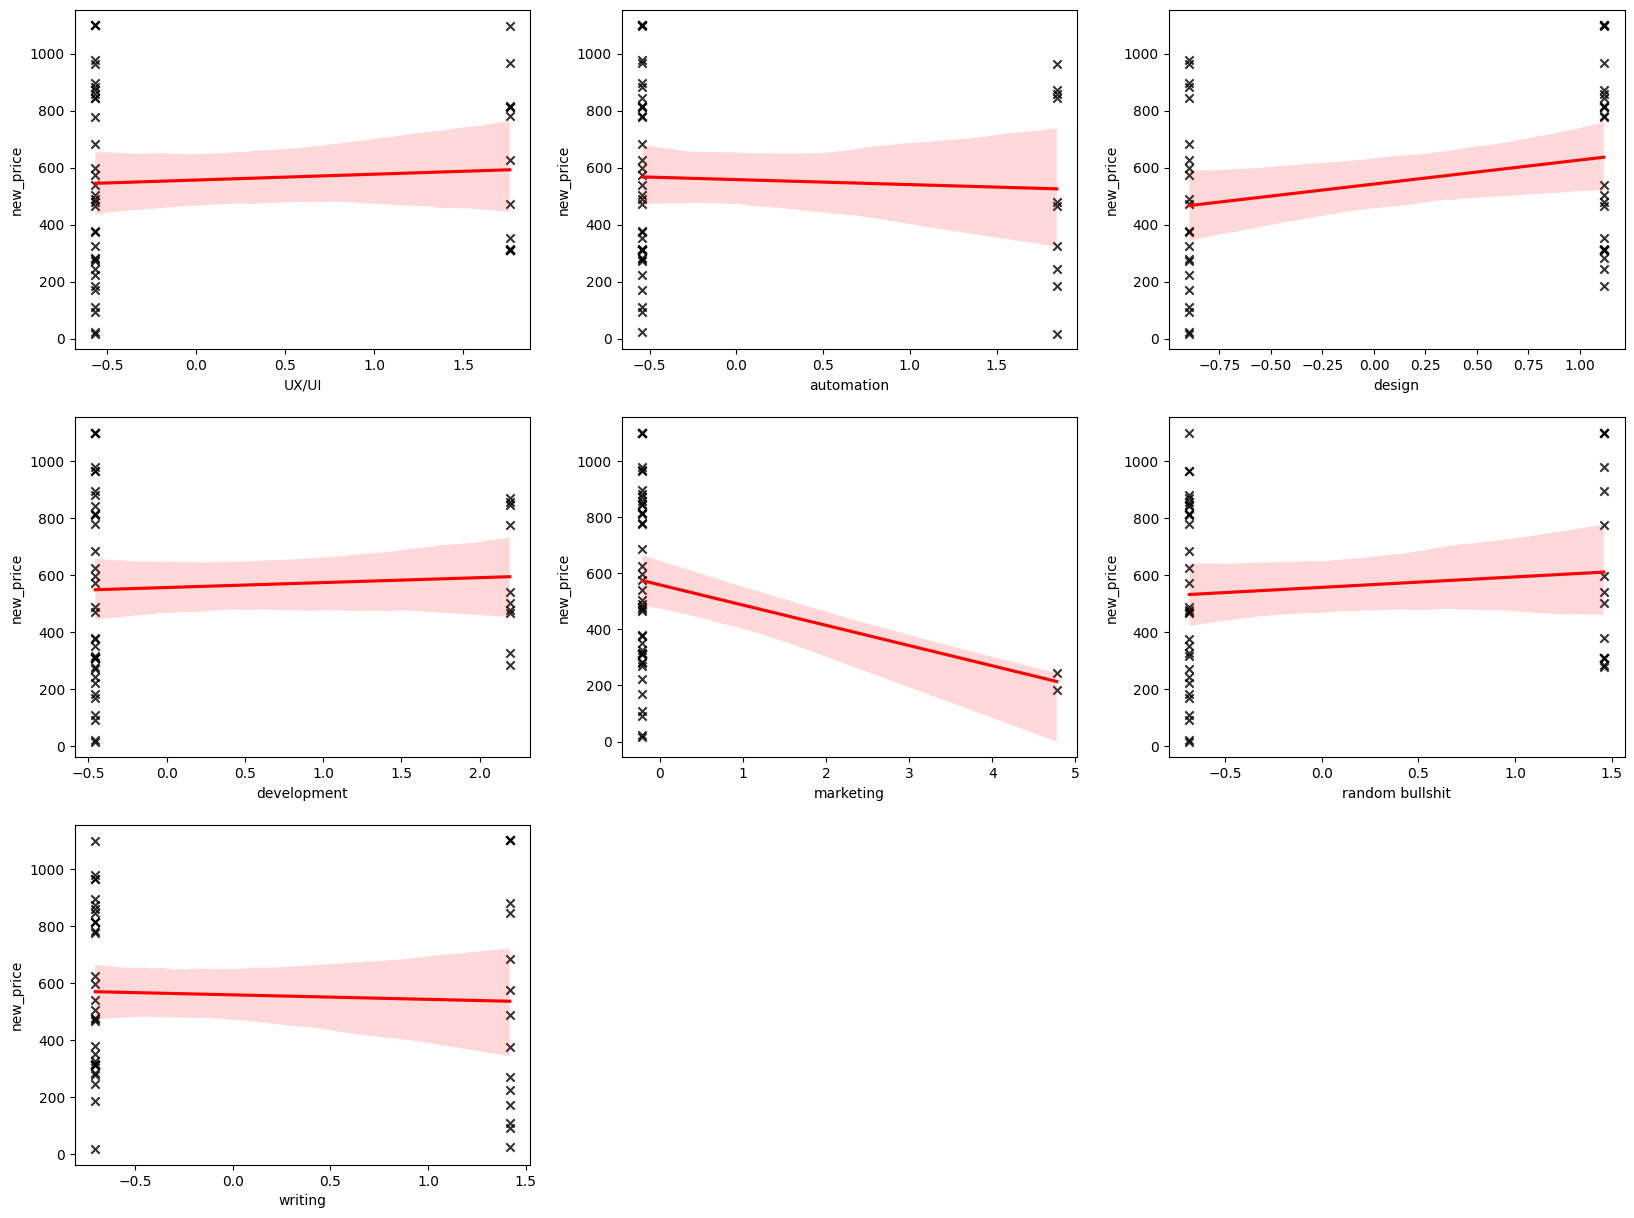

In [15]:
plt.figure(figsize=(20, 15))

for i in range(X_test.shape[1]):
    plt.subplot(3, 3, i + 1)
    plt.xlabel(mlb.classes_[i])
    sns.regplot(x=X_test[:, i], y=y_test, marker="x", scatter_kws={"color": "black"}, line_kws={"color": "red"})

plt.show()

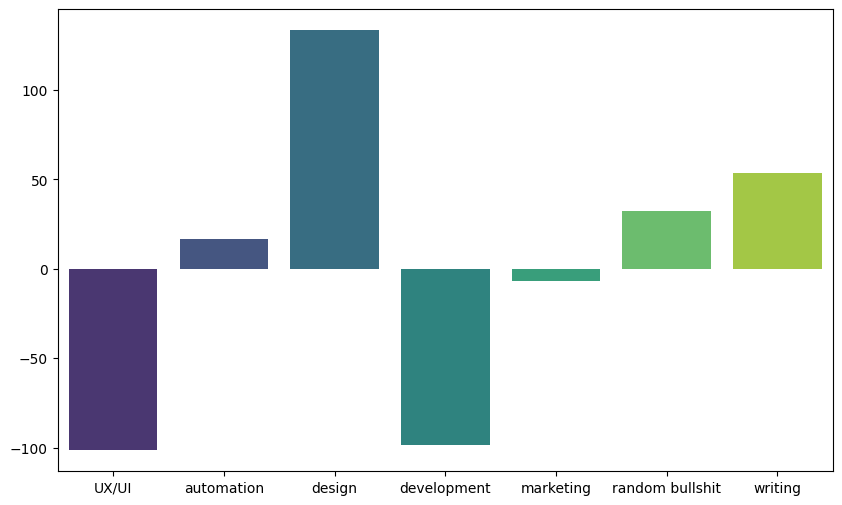

In [16]:
plt.figure(figsize=(10, 6))

sns.barplot(x=mlb.classes_, y=model.coef_, hue=mlb.classes_, palette="viridis")

plt.show()